# Project

ChatGPT helped write the code required for using the `scikit-learn` and `tensorflow` implementations.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Mean Squared Error on Test Stock 'AAPL': 1.405996016493846e-06


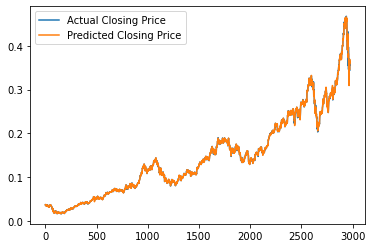

Mean Squared Error on Test Stock 'AMZN': 0.00010624621058351517


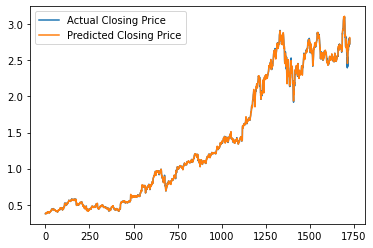

Mean Squared Error on Test Stock 'FB': 3.527738517638648e-06


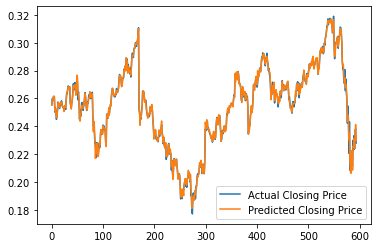

Mean Squared Error on Test Stock 'GOOGL': 7.517238388790037e-05


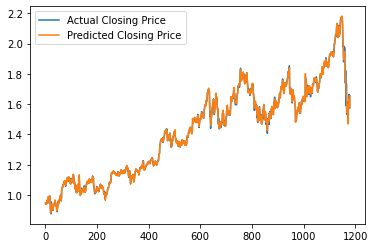

Mean Squared Error on Test Stock 'MSFT': 5.03577659314079e-07


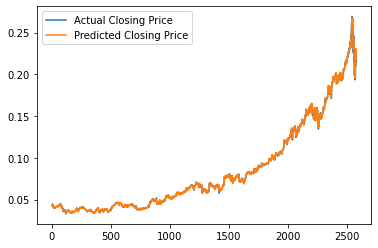

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import glob

all_files = glob.glob('*.csv')
df_list = []

for csv in all_files:
    df = pd.read_csv(csv)
    df['Stock'] = csv.split('.')[0]
    df_list.append(df)
data = pd.concat(df_list, ignore_index=True)
data = data.sort_values(['Stock', 'Date'])

train_list = []
test_data_mapping = {}

for stock in data['Stock'].unique():
    stock_data = data[data['Stock'] == stock]
    split_index = int(len(stock_data) * 0.7)
    train_data = stock_data.iloc[:split_index]
    test_data = stock_data.iloc[split_index:]
    train_list.append(train_data)
    test_data_mapping[stock] = test_data
train_data = pd.concat(train_list, ignore_index=True)

train_prices = train_data[['Open', 'Low', 'High', 'Close']].values
num_features = train_prices.shape[1] - 1

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_prices)

# Model training
X_train, Y_train = scaled_train[:, :num_features], scaled_train[:, num_features]
model = LinearRegression()
model.fit(X_train, Y_train)

# Function to test the model on a selected stock's test set
def test_on_stock(stock_name):
    test_data = test_data_mapping.get(stock_name)
    if test_data is None:
        print(f"Test data for stock '{stock_name}' not found.")
        return
    
    # Process and scale the test data
    test_prices = test_data[['Open', 'Low', 'High', 'Close']].values
    scaled_test = scaler.transform(test_prices)
    X_test, Y_test = scaled_test[:, :num_features], scaled_test[:, num_features]
    
    # Make predictions and evaluate
    predictions = model.predict(X_test)
    mse = mean_squared_error(Y_test, predictions)
    print(f"Mean Squared Error on Test Stock '{stock_name}':", mse)

    import matplotlib.pyplot as plt
    plt.plot(Y_test, label='Actual Closing Price')
    plt.plot(predictions, label='Predicted Closing Price')
    plt.legend()
    plt.show()

for stock in data['Stock'].unique():
    test_on_stock(stock)

https://pieriantraining.com/tensorflow-lstm-example-a-beginners-guide/

In [ ]:
%%time
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

train_data = scaled_prices[:train_size]
val_data = scaled_prices[train_size:train_size + val_size]
test_data = scaled_prices[train_size + val_size:]

def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :num_features])  # Using 'open' price as input
        y.append(data[i + sequence_length, num_features])    # Predict 'close' price
    return np.array(X), np.array(y)

sequence_length = 60  # Number of days in each sequence
X_train, Y_train = create_sequences(train_data, sequence_length)
X_val, Y_val = create_sequences(val_data, sequence_length)
X_test, Y_test = create_sequences(test_data, sequence_length)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], num_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], num_features))

model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, num_features)),
    Dense(1)  # Predicting a single value (close price)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=[early_stopping]
)

test_loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test Loss (MSE): {test_loss}')

# Predict and inverse transform for interpretability
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(np.concatenate([np.zeros((predicted.shape[0], num_features)), predicted], axis=1))[:, num_features]
actual = scaler.inverse_transform(np.concatenate([np.zeros((Y_test.shape[0], num_features)), Y_test.reshape(-1, 1)], axis=1))[:, num_features]

# Optional: Plot results
import matplotlib.pyplot as plt
plt.plot(actual, label='Actual Closing Price')
plt.plot(predicted, label='Predicted Closing Price')
plt.legend()
plt.show()

2024-11-01 17:06:02.092229: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 17:06:02.187945: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 17:06:02.295324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730495162.379959   10227 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730495162.409228   10227 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 17:06:02.588144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/50


2024-11-01 17:06:04.741656: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 8.6485e-04 - val_loss: 0.0066
Epoch 2/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 6.9241e-04 - val_loss: 0.0068
Epoch 3/50
246/658 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 6.7121e-04